In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

import os
import sys
import subprocess
import pandas as pd

import matplotlib.backends.backend_pdf

#path = '/Users/nicomedinap/Dropbox/scripts'
#sys.path.append(os.path.abspath(path))
#from functions import *

fecha = '23Marzo2021'

Primero, escribiremos lo que quiero lograr con esto:

- [x] Entender y definir el camino hasta donde estarán los datos.
- [x] Poder leer uno a uno los catálogos individuales y crear versiones únicas de los catálogos.
- [ ] Implementar un set de funciones para python3
- [ ] Aplicar FATS, para poder obtener features
- [ ] Mas?

In [56]:
def PSA(cat, period, path, N_frec=2, ID=None, tile='b317',sigmaClip=3, columnadoble='False',fz=15,ms=6, plot=True):
    """
    periodic sources analysis (PSA)
    Analiza y plotea las candidatas periodicas dadas ciertas condiciones
    """
    import os
    import sys
    import subprocess
    import matplotlib.pylab as plt
    import numpy as np
    
    lc = np.genfromtxt(path+'/'+cat) 
    mjd,mag,err = lc[:,0],lc[:,1],lc[:,2]

    #Constante para normalizar los dias julianos: 
    mjd0=min(mjd)
    
    #guardamos los valores de la serie de tiempo antes de la manipulacion:
    mjd_old = mjd[:]
    mag_old = mag[:]
    err_old = err[:]

    Dks = max(mag)-min(mag)
    
    #Normalizamos el espacio de fase, no el tiempo:
    indx = np.argmax(mag)
    Mjd0 = mjd[indx] 
    MJD = mjd-Mjd0    
    phase = (MJD/period) % 1

    #Calculamos los parametros de la serie de Fourier y el ajuste:
    A0,f_amp,f_phs,ajuste = fourier_param(mjd,mag,err,period,nf=N_frec,plot=0,stats=0,descomp=0)
    
    #############################################

    #Ordenamos la curva de luz en el espacio de fase:
    sort = np.array([(mag[j],phase[j],err[j],mjd[j]) for j in range(len(mag))])
    sort = sort[np.argsort(sort[:,1])]
    phase = sort[:,1]
    mag = sort[:,0]
    err = sort[:,2]
    #tambien guardamos mjd para volver a construrir la curva de luz:
    mjd_sort = sort[:,3]

    ##############################################

    #Calculamos los residuos (datos-modelos)
    Residuos_fourier = mag-ajuste
    
    #plt.hist(Residuos_fourier,bins=nbins(Residuos_fourier),color='black',normed=True)

    #Ajustamos una Gaussiana a los residuos del ajuste:
    guess = [np.mean(Residuos_fourier),np.std(Residuos_fourier),1] #[mu,sigma,altura]
    Mu_g,Sigma_g,Ampl_g = fit_gauss(Residuos_fourier,guess,plot=0,Nbins=nbins(Residuos_fourier),normed=True)
    
    #histograma:
    #No lo uso, pero lo dejo, nunca esta de mas tener esta version del histograma
    #(altura, bins) = np.histogram(Residuos_fourier,bins=nbins(Residuos_fourier), normed=True)
    #hist = np.array([ (bins[i]+bins[i+1])/2. for i in range(len(bins)-1)])

    #parametros para visualizar la gaussiana:
    xi = np.linspace(min(Residuos_fourier),max(Residuos_fourier),1000)
    g = Gaussian(Mu_g,Sigma_g,Ampl_g, xi)

    #Calculamos la bondad del ajuste:
    z = 1.0 /(err**2)
    chi2 = sum((Residuos_fourier**2)*z)/(len(Residuos_fourier)-1.)

    #print "Bondad del ajuste (sin sigma-clipping)->",chi2

    ################################################################################

    #Usaremos el Sigma del primer ajuste para hacer el sigma_clipping:
    #Aplicamos sigma-clipping
    sigmaClip=sigmaClip
    fac = sigmaClip*Sigma_g
    #Retiramos los puntos usando el factor correspondiente:
    selec = np.array([(Residuos_fourier[j],phase[j],mag[j],err[j],mjd_sort[j])\
                      for j in range(len(Residuos_fourier)) if (-fac<Residuos_fourier[j]<fac)])

    fuera = np.array([(Residuos_fourier[j],phase[j],mag[j],err[j],mjd_sort[j])\
                      for j in range(len(Residuos_fourier)) if ( (Residuos_fourier[j]>fac) or (Residuos_fourier[j]<-fac)) ])  
    
    #Seleccionamos los nuevos a considerar para las estadisticas:
    s_residuos = selec[:,0]
    s_phase = selec[:,1]
    s_mag = selec[:,2]
    s_err = selec[:,3]
    s_mjd = selec[:,4]

    #####################################################################

    #Segundo paso, calculamos nuevamente la serie de fourier:
    #Ordenamos la curva de luz
    #sort_mjd = np.array([(s_mag[j],s_phase[j],s_err[j],s_mjd[j]) for j in range(len(s_mag))])
    #sort_mjd = sort_mjd[np.argsort(sort_mjd[:,3])]

    #mjd = sort_mjd[:,3]
    #mag = sort_mjd[:,0]
    #err = sort_mjd[:,2]    

    #Segundo calculo de la serie de fourier:
    #A0,f_amp,f_phs,ajuste_clip = fourier_param(mjd,mag,err,period,nf=N_frec,plot=0,stats=0,descomp=0)

    #volvemos a espacio de fase:
    #sort_phase = np.array([(s_mag[j],s_phase[j],s_err[j],s_mjd[j],ajuste_clip[j]) for j in range(len(s_mag))])
    #sort_phase = sort_phase[np.argsort(sort_phase[:,1])]

    #s_phase = sort_phase[:,1]
    #s_mag = sort_phase[:,0]
    #s_err = sort_phase[:,2]
    #s_ajuste_clip = sort_phase[:,4]
    

    #Volvemos a calcular la bondad:
    #res_clip = s_mag-ajuste_clip
    
    #print 'prueba1'    
    #plt.plot(s_phase,s_mag,'.r')    
    #plt.plot(s_phase,s_ajuste_clip,'.g')    
    #plt.show()
    
    #plt.hist(res_clip,bins=nbins(res_clip),color='red',normed=True)
    
    z = 1.0 /(s_err**2)
    chi2_clip = sum((s_residuos**2)*z)/(len(s_mag)-1.)

    #Ajustamos la nueva distribucion de residuos:
    guess = [np.mean(s_residuos),np.std(s_residuos),1]
    Mu_clip,Sigma_clip,Ampl_clip = fit_gauss(s_residuos,guess,plot=False,Nbins=nbins(s_residuos),normed=True)

    ################################################################################################
    ################################################################################################
    #Parametros arbitrarios:
    ################################################################################################
    ################################################################################################
    
    fz=15
    ms=6
    
    fz=fz
    ms=ms


    #SERIE DE TIEMPO:
    
    lc = np.genfromtxt(path+'/'+cat) 
    mjd,mag,err = lc[:,0],lc[:,1],lc[:,2]


    if columnadoble== True:
        plt.figure(figsize=(8,4))
        grid = plt.GridSpec(ncols=5, nrows=2, wspace=0.4, hspace=1.)#, width_ratios=[5,1,1,1])
    else:
        plt.figure(figsize=(18,3))
        grid = plt.GridSpec(ncols=11, nrows=1, wspace=0.6, hspace=1.5)#, width_ratios=[5,1,1,1])

    if columnadoble== True:  
        plt.subplot(grid[0,:3])
    else:
        plt.subplot(grid[0, :-7])
    #Normalizamos el tiempo a que parta de cero:
    MJD = mjd - mjd0
    if ID != None:
        plt.title(ID,loc='left',fontsize=fz)
    else:
        plt.title(cat,loc='left',fontsize=fz)

    plt.title(r'${ \rm \Delta K_{s}=%0.2f}$' %Dks,loc='right',fontsize=fz)   
    plt.errorbar(MJD, mag, err,0, 'ko', ecolor='gray', alpha=0.8, ms=ms)
    
    #ploteamos los puntos eliminados del sigma-clipping
    if len(phase)!=len(selec[:,1]):
        var=1
    #    if len(fuera[:,0])!=0:
        #Normalizamos el tiempo:
        plt.errorbar(fuera[:,4]-mjd0,fuera[:,2],fuera[:,3],0,'ro', ecolor='gray', alpha=0.8,ms=ms)
    
    #plt.xlim(-30,max(MJD) + 30)
    plt.xlabel('MJD-%0.1f [d]' %mjd0,fontsize=fz)
    plt.ylabel("$K_{s}$ [mag]",fontsize=fz)
    holi = np.linspace(np.min(mag)-np.mean(err),np.max(mag)+np.mean(err),4)
    rango = np.array([round(holi[i],2) for i in range(len(holi))])
    plt.yticks(rango,fontsize=fz)
    plt.xticks(fontsize=12)
    plt.gca().invert_yaxis()

    ################################################################################################

    if columnadoble== True:  
        plt.subplot(grid[0,3:])
    else:
        plt.subplot(grid[0,-7:-5])    
       
    phase = ((mjd-Mjd0)/period) % 1
    sort = np.array([(mag[j],phase[j],err[j],mjd[j]) for j in range(len(mag))])
    sort = sort[np.argsort(sort[:,1])]
    phase = sort[:,1]
    mag = sort[:,0]
    err = sort[:,2]
    
    if period > 10:
        plt.title('$P=%0.1f$' %period,loc='left',fontsize=fz)
    else:
        plt.title('$P=%0.3f$' %period,loc='left',fontsize=fz)
    plt.title('$Freq=%i$' %N_frec,loc='right',fontsize=fz)

    #ploteamos en rojo para visualizar los puntos retirados:
    plt.errorbar(phase,  mag,    err,0,'ko',ms=ms, ecolor='gray')

    if len(phase)!=len(selec[:,1]):
        plt.errorbar(fuera[:,1],fuera[:,2],fuera[:,3], 0,'or',ms=ms)

    #Visualizamos:
    def Serie_Fourier(t,A0,Ampl, fases): 
        """
        Funcion que genera una serie de fourier en el espacio t, dada la amplitud A0, las amplitudes Ampl, las fases y el periodo.
        """
        period=1 #el periodo acá es 1 porque estamos en el espacio de fase.
        w = 2.0*np.pi/period
        return A0 + sum(np.array([Ampl[k]*np.sin((k+1)*w*t + fases[k]) for k in range(len(Ampl))]))
    
    xii = np.linspace(0,1,1000)

    if plot==True:

        plt.plot(xii, Serie_Fourier(xii,A0,f_amp,f_phs), 'r-', lw=3)
        plt.xticks([0,0.5,1],fontsize=fz)
        plt.yticks(fontsize=0)
        plt.xlabel('$\phi$',fontsize=fz)
        plt.gca().invert_yaxis()

        ################################################################################################
        
        if columnadoble== True:  
            plt.subplot(grid[1, :3])
            plt.ylabel('$\epsilon$',fontsize=fz)
        else:   
            plt.subplot(grid[0,-5:-2])
        
        plt.title( tile,loc='left',fontsize=fz)
        plt.plot([min(phase),max(phase)], 0*np.ones(2),'k-')
        plt.plot([min(phase),max(phase)], 2*Sigma_g*np.ones(2),'-',color='red',label="$2 \sigma$")
        plt.plot([min(phase),max(phase)],-2*Sigma_g*np.ones(2),'-',color='red')
        plt.plot([min(phase),max(phase)], 3*Sigma_g*np.ones(2),'--',color='red',label="$3 \sigma$")
        plt.plot([min(phase),max(phase)],-3*Sigma_g*np.ones(2),'--',color='red')
    #   plt.legend(loc='best',fontsize=6)
        plt.errorbar(s_phase,s_residuos,s_err,0,'o',ms =ms, ecolor='gray', mec='green', mfc='green',)  

        #ploteamos los puntos eliminados del sigma-clipping
        if len(phase)!=len(selec[:,1]):
        #if len(fuera[:,0])!=0:
            plt.errorbar(fuera[:,1],fuera[:,0],fuera[:,3],0,'o',ms =ms,color='red')

        plt.xlabel('$\phi$',fontsize=fz)
        plt.xticks(fontsize=fz)
        plt.yticks(fontsize=10)
        plt.title('$\sigma=%0.1g$' %Sigma_g,loc='center',fontsize=fz)
        plt.ylim(-(sigmaClip+2)*Sigma_g,(sigmaClip+2)*Sigma_g)


        ################################################################################################

        if columnadoble== True:  
            plt.subplot(grid[1,3:])
        else:   
            plt.subplot(grid[0,-2:])

        plt.title('$\chi^{2}=%0.2f\ \ \chi^{2}_{clip}=%0.2f$' %(chi2,chi2_clip),loc='right',fontsize=fz)
    #Histograma completo   
        _=plt.hist(Residuos_fourier,bins=nbins(Residuos_fourier),color='black',density=True\
            ,orientation='horizontal',lw=6,label='No clip')
    #Histograma del sigma clip
        _=plt.hist(selec[:,0],bins=nbins(selec[:,0]),color='green', histtype='step',density=True\
            ,orientation='horizontal',lw=4,label='Clip')
        
        xi = np.linspace(min(selec[:,0])-5*min(selec[:,0]),max(selec[:,0])+5*min(selec[:,0]),1000)
        g = Gaussian(Mu_clip,Sigma_clip,Ampl_clip, xi)
        plt.plot(g,xi,'-r',lw=3,label='fit')
        
        plt.xlabel(r'${\rm Frequency}$',fontsize=fz-2)
        plt.xticks(fontsize=fz)
        plt.yticks(fontsize=10)
        plt.ylim(-(sigmaClip+2)*Sigma_g,(sigmaClip+2)*Sigma_g)

        plt.legend(loc='best',fontsize=10)

        if columnadoble== False:  
            ax2 = plt.twinx()
            ax2.set_ylabel('$\epsilon$',fontsize=fz+3)
            ax2.set_yticklabels([]) 
            
        plt.subplots_adjust(hspace=.1)
        plt.tight_layout()
        plt.gcf().subplots_adjust(bottom=0.2)

    return chi2,chi2_clip,Sigma_clip,f_amp,f_phs


In [57]:
path_datos='/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/'

#lista_tiles = np.genfromtxt('./'+subgrupo+'lista_tiles.cat', dtype=str)



In [58]:
def fourier_param(mjd,mag,err,period,nf=4,mjd0=None,plot=True,stats=True,descomp=False,size=(12,3)):
    
    """
    Entrega la fase y la amplitud de una serie de Fourier ajustada a una serie de tiempo
    Entrada: 
    mjd,mag,err: tiempo, magnitud y errores.
    period: periodo de la señal.
    nf: número de armónicos de la serie de fourier.
    plot: Mostrar el ajuste a los datos.
    stats: mostrar los valores obtenidos.
    descomp: Muestra las funciones sinusoidales por separado
    size: Tamaño de los graficos
    
    Salida:
    A0: Constante
    amp_flatten,phs_flatten: Amplitudes y fases.
    ajuste: Datos del ajuste.
    """
    
    import math
    import matplotlib.pylab as plt
    import numpy as np
    
    if mjd0==None:
	#Calculamos cual es la magnitud minima para normalizar el espacio de fase, haciendo que el minimo este en 1
        indx = np.argmax(mag)
        mjd0 = mjd[indx]
        MJD = mjd - mjd0
    else:
        MJD = mjd - mjd0
    
    #Asi, restamos mjd por mjd0
    phase = (MJD/period) % 1
    #ordenamos las magnitudes para compararlas con el modelo:
    sort = np.array([(mag[i],phase[i],err[i]) for i in range(len(mag))])
    sort = sort[np.argsort(sort[:,1])]
    phase = sort[:,1]
    mag = sort[:,0]
    err = sort[:,2]

    #period of the signal
    per=1
    w = 2.0*np.pi/per
    #number of fourier components.
    nf = nf

    # m1 is the number of unknown coefficients.
    m1 = 2*nf + 1
    # Create empty matrices.
    x = np.zeros((m1,m1))
    y = np.zeros((m1,1))
    xi = [0.0]*m1

    # Read (time, value) from each line of the file.
    for i in range(len(mag)):
        xi[0] = 1.0
        for k in range(1,nf+1):
            xi[2*k-1] = np.sin(k*w*phase[i])
            xi[2*k] = np.cos(k*w*phase[i])
        for j in range(m1):
            for k in range(m1):
                x[j,k] += xi[j]*xi[k]
            y[j,0] += mag[i]*xi[j]

    # Copy to big matrices.
    X = np.mat( x.copy() )
    Y = np.mat( y.copy() )
    # Invert X and multiply by Y to get coefficients.
    A = X.I*Y
    A0 = A[0,0]

    # Solution is A0 + Sum[ Amp*sin(k*wt + phi) ]
    if stats==True:
        print("First %g fourier components:" %nf)
        print("<Ks> = %g" % A[0])
        for k in range(1,nf+1):
            amp = math.sqrt(A[2*k-1]**2 + A[2*k]**2)
            phs = math.atan2(A[2*k],A[2*k-1])
            print("amp[%d] = %0.3g  phi[%d] = %0.4g" % (k-1, amp,k-1, phs))

    amp = np.array([np.sqrt((A[2*k-1])**2 + (A[2*k])**2) for k in range(1,nf+1)])
    phs = np.array([math.atan2(A[2*k],A[2*k-1]) for k in range(1,nf+1)])
    
    amp_flatten = amp.flatten()
    phs_flatten = phs.flatten()
    
    #dentro del seno, k debe ser k+1, porque el indice parte de cero :(
    def term(t): return np.array([amp[k]*np.sin((k+1)*w*t + phs[k]) for k in range(len(amp))])

    ajuste = np.array([A0+sum(term(phase[i])) for i in range(len(mag))])
    ajuste = ajuste.flatten()
    
    if descomp==True:
        plt.figure(figsize=size)
        plt.title('Fourier descomposition',loc='center',fontsize=15)
        plt.xlabel('$\phi$',fontsize=18)
        plt.ylabel("Amplitude",fontsize=16)
        
        fase = np.linspace(0,1,1000)
        def term(t,k): return A0 + amp_flatten[k]*np.sin((k+1)*w*t + phs_flatten[k])
        for k in range(nf):
            plt.plot(fase,term(fase,k))
        plt.gca().invert_yaxis()
        #plt.show()
    
    if plot==True:
        plt.figure(figsize=size)
        plt.title('Period: %.6f [d]' %period,loc='right',fontsize=13)
        plt.xlabel('$\phi$',fontsize=18)
        plt.ylabel("$K_{s}$ [mag]",fontsize=16)
        plt.plot(phase,ajuste,color='red',lw=2)
        plt.errorbar(phase,mag,err,0,'ok')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        
    phs = phs_flatten
    amp = amp_flatten
        
    return A0,amp,phs,ajuste

In [59]:
def nbins(X):
    """
    Taken from http://toyoizumilab.brain.riken.jp/hideaki/res/histogram.html
    """
    import numpy as np

    x_max = np.max(X)
    x_min = np.min(X)
    N_MIN = 5  #Minimum number of bins (integer)
               #N_MIN must be more than 1 (N_MIN > 1).
    N_MAX = 100  #Maximum number of bins (integer)
    N = range(N_MIN,N_MAX) # #of Bins
    N = np.array(N)
    D = (x_max-x_min)/N    #Bin size vector
    C = np.zeros((len(D),1))

    #Computation of the cost function
    for i in range(np.size(N)):
        edges = np.linspace(x_min,x_max,N[i]+1) # Bin edges
        ki = np.histogram(X,edges) # Count # of events in bins
        ki = ki[0]    
        k = np.mean(ki) #Mean of event count
        v = sum((ki-k)**2)/N[i] #Variance of event count
        C[i] = (2*k-v)/((D[i])**2) #The cost Function
    #Optimal Bin Size Selection
    cmin = min(C)
    idx  = np.where(C==cmin)
    
    #print idx

    try:
        idx = int(idx[0])
    except TypeError:
        idx = 10
        return 10

    #print idx

    optD = D[idx]

    edges = np.linspace(x_min,x_max,N[idx]+1)
    #plt.hist(X,edges, normed=True)
    #title(u"Histogram")
    #ylabel(u"Frequency")
    #xlabel(u"Value")
    return len(edges)-1

In [60]:
def Gaussian(mu,sigma,amp,x):
    """
    """
    import numpy as np
    return amp*np.exp(-0.5*((x - mu)/sigma)**2) 

In [61]:
def fit_gauss(X,guess,plot=False,large=[6,4],normed=True,xlabel='',Nbins=None,lw=3,fontsize=15,points=False):
    """
    Ajusta una función gaussiana a una distribucion dada.
    Entrada: 
    X: Distribucion.
    guess: Valores iniciales para realizar el ajuste (guess=[mu,sigma,amplitud])
    plot: mostrar el ajuste.
    large: tamaño del plot.
    normed: Si se normaliza el histograma y la funcion.
    
    Salida:
    mu: Valor medio de la gaussiana.
    sigma: desviacion estandar del ajuste.
    amplitud: amplitud de la funcion.
    """
        
    from scipy import optimize
    import numpy as np
    import matplotlib.pyplot as plt 

    if Nbins == None:
        Nbins=nbins(X)
    
    (altura, bins) = np.histogram(X, bins=Nbins, density=normed)
        
    hist = np.array([ (bins[i]+bins[i+1])/2. for i in range(len(bins)-1)])
    
    def gaussian(val, x):
        return (val[2])*np.exp(-0.5*((x - val[0])/val[1])**2)

    def chi2(val,x,y):
        return (y-gaussian(val, x))**2 #Asumiendo que los errores son 1
    
    x = np.linspace(np.min(X),np.max(X),Nbins)
    
    xi = np.linspace(np.min(X),np.max(X),1000)
    
    fit = optimize.leastsq(chi2,guess,args=(hist,altura))
  
    mu = fit[0][0]
    sigma = abs(fit[0][1])
    ampl = abs(fit[0][2])
    
    #print "mu = %f, sigma = %f, ampl = %f " % (mu,sigma,ampl)
    
    if plot==True:
        plt.figure(figsize=large)
        if normed == True:
            plt.ylabel(r'${\rm Normalized Amplitude }$',fontsize=fontsize)
        else:
            plt.ylabel(r'${\rm Amplitude }$',fontsize=fontsize)

        plt.xlabel(r'${\rm %s }$' %xlabel,fontsize=fontsize)    
        a,b,c=plt.hist(X,Nbins,density=normed)

        if points==True:
            plt.plot(hist,altura,'o--',color='green')
        plt.plot(xi,gaussian(fit[0],xi),'-',color='red',linewidth=lw, label='Gaussian fit')

    return mu,sigma,ampl

In [62]:
def ReadFile(filename,path=None,ReadStr=True):
    """
    Cuando ReadStr es True, Lee un archivo ascii sin tener que puntualizar formatos.
    
    Entrada:
    filename: nombre del archivo a leer.
    path: directorio donde se aloja.
    
    Salida:
    archivo: np.array con los valores leídos.
    """
   
    import numpy as np
    import os
    import sys
    
    if ReadStr==False:
        if path!=None:
            sys.path.append(os.path.abspath(path))
            f1 = open(os.path.join(path, filename), "r")  
            data = np.genfromtxt(f1)
        else:
            data= np.genfromtxt(filename)
            
        return data
        
    else:  
        if path!=None: 
            sys.path.append(os.path.abspath(path))
            f1 = open(os.path.join(path, filename), "r")  
            data = np.genfromtxt(f1,dtype=None,unpack=True) 
        else:
            data= np.genfromtxt(filename,dtype=None,unpack=True,encoding=None)

        data_tup = tuple(np.empty(len(data), dtype=data.dtype[i]) for i in range(len(data[0])))
        for i, line in enumerate(data):
            for j, item in enumerate(line):
                data_tup[j][i] = item

        f = len(data_tup)

        for i in range(f):    
            if i==0:
                try:
                    archivo = data_tup[i].astype(np.object)
                except:
                    archivo = data_tup[i]
            else:
                try:
                    archivo = np.column_stack((archivo,data_tup[i].astype(np.object)))  
                except:
                    archivo = np.column_stack((archivo,data_tup[i]))  
        return archivo 

In [63]:
def Coords(cat):
    """
    Usa las coordenadas en el nombre del catálogo para guardar las coordenadas en Ra y Dec.
    Funciona sólo para las series de tiempo que yo produzco.
    """
    Ra,dec=cat.split('-')
    dec,blah=dec.split('.lc')
    Dec = str('-')+str(dec)
    return float(Ra),float(Dec)

In [64]:
def Readlc(Catname,path=None):
    """
    Función para leer las curvas de luz dado el nombre y la dirección
    retorna; mjd,mag,err
    """
    lc = ReadFile(Catname,path=path,ReadStr=False)
    mjd,mag,err = lc[:,0],lc[:,1],lc[:,2]
    return mjd,mag,err

In [82]:
def DKs_bootstrap(mag,iteraciones=1000,porcentaje=0.5,show_hist=False):
    """
    Realiza la medición de la amplitud, y estima el error usando bootstrap.
    Entrada:
    iteraciones: Repeticiones del bootstrap.
    porcentaje: % de datos que se retiran de la muestra para hacer el cálculo.
    retorna; MeanKs, error
    """
    import matplotlib.pylab as plt
    import numpy as np
    from random import sample

    N = len(mag)-1

    bootstrap = np.zeros(iteraciones)

    #Porcentaje de datos a retirar de la muestra
    porcent = int(len(mag)*porcentaje)

    for i in range(iteraciones):
        #Sample toma N2-porcent numeros random de mag, así creamos nuestra muestra por bootstrap.
        MAG = sample(list(mag),N-porcent)
        bootstrap[i] = max(MAG)-min(MAG)

    mean = np.mean(bootstrap)
    std  = np.std(bootstrap,ddof=1)

    if show_hist==True:
        plt.hist(bootstrap)
        plt.show()

    return mean,std

In [80]:
def MeanKs_bootstrap(mag,iteraciones=1000,porcentaje=0.1,show_hist=False):
    """
    Realiza la medición de la magnitud media, y estima el error usando bootstrap.
    Entrada:
    iteraciones: Repeticiones del bootstrap.
    porcentaje: % de datos que se retiran de la muestra para hacer el cálculo.
    retorna; MeanKs, error
    """
    import matplotlib.pylab as plt
    import numpy as np
    from random import sample

    N = len(mag)-1

    bootstrap = np.zeros(iteraciones)

    #Porcentaje de datos a retirar de la muestra
    porcent = int(len(mag)*porcentaje)

    for i in range(iteraciones):
        #Sample toma N2-porcent numeros random de mag, así creamos nuestra muestra por bootstrap.
        MAG = sample(list(mag),N-porcent)
        bootstrap[i] = np.mean(MAG)

    mean = np.mean(bootstrap)
    std  = np.std(bootstrap,ddof=1)

    if show_hist==True:
        plt.hist(bootstrap)
        plt.show()

    return mean,std

In [84]:
def eta(t,mag):    
    import numpy as np
    N = len(t)
    sigma = np.std(mag)
    
    term = sum(np.array( [(mag[n+1]-mag[n])**2 for n in range(0,N-1)]))
    eta = (1./((N-1)*sigma**2))*term
    return eta 

In [85]:
lista_tiles = np.genfromtxt('Lista_directorios.txt', dtype=str)

print(lista_tiles)

#pdf = matplotlib.backends.backend_pdf.PdfPages('CatalogoCompleto_'+fecha+'.pdf')

f = open('CatalogoCompleto_'+fecha+'.cat','w')
f.write('#Ra		 Dec		 Cat				 TileID	 Epochs  DKs	 DKsboot meanKs	 meanErr P	 	 Eta	 Poder	 chi2	 chi2_cl Sigmacl f_amp1	f_amp2	f_phs1	f_phs2\n')

#Seteamos parametros arbitrarios:
c=0 #Contador de variables
nfrec = 2 #numero de frecuencias

for directorio in lista_tiles:
    tile, info_inutil = directorio.split('_')
    
    local_path= path_datos+directorio+'/GLS/'
    print(local_path)
    GLS = ReadFile('GLS_cand.list', path=local_path)
    #GLS = np.genfromtxt(local_path+'GLS_cand.list')
    
    #vamos a elegir las que tengan Power > 0.5
    Sample = np.array([GLS[i] for i in range(len(GLS[:,0])) if GLS[i,7]>0.5])
    cat = Sample[:,2]
    P = Sample[:,8]
    Power = Sample[:,7]
    
    #Creamos un contador para asignar nombres genericos a la variables
    numeroID=1
        
    for j in range(len(cat)):
        c +=1
        #hay que hacer una corrección por tipo de bytes a str:
        CAT = cat[j].decode("utf-8") 
        lc = np.genfromtxt(local_path+'/'+CAT) 
        #print(lc)
        mjd,mag,err = lc[:,0],lc[:,1],lc[:,2]
            
        #mjd,mag,err = Readlc(cat[j],path=local_path)
        
        Ra,Dec  = Coords(CAT)
        Epochs = len(mjd)
        meanKs, meanErr = MeanKs_bootstrap(mag)
        DKs_boot,DKs_err = DKs_bootstrap(mag)
        Poder  = Power[j]
        tileID = tile
        Eta = eta(mjd,mag)
        ID = tile+'_'+str(numeroID)
        
        chi2,chi2_clip,Sigma_clip,f_amp,f_phs = PSA(CAT, P[j], path=local_path, plot=False,\
                        N_frec=nfrec, sigmaClip=3, ID=CAT, tile=ID, columnadoble=False)
        #plt.tight_layout()
        #pdf.savefig()
        plt.close()
        f.write("%0.7f\t%0.7f\t%s\t%s\t%g\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%0.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n" \
        %(Ra,Dec,CAT,ID,Epochs,DKs_boot,DKs_err,meanKs,meanErr,P[j],Eta,Poder,chi2,chi2_clip,Sigma_clip,f_amp[0],f_amp[1],f_phs[0],f_phs[1]))
        f.flush()
        numeroID +=1
        
f.close()
#pdf.close()
print(c)

['b313_data' 'b314_data' 'b315_data' 'b316_data' 'b317_data' 'b318_data'
 'b319_data' 'b320_data' 'b321_data' 'b322_data' 'b323_data' 'b324_data'
 'b327_data' 'b328_data' 'b329_data' 'b330_data' 'b331_data' 'b332_data'
 'b335_data' 'b336_data' 'b337_data' 'b338_data' 'b339_data' 'b340_data'
 'b341_data' 'b342_data' 'b344_data' 'b345_data' 'b346_data' 'b347_data'
 'b348_data' 'b349_data' 'b350_data' 'b351_data' 'b352_data' 'b353_data'
 'b354_data']
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b313_data/GLS/


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b314_data/GLS/


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b315_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b316_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b317_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b318_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b319_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b320_data/GLS/


/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:449: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b321_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b322_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b323_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b324_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b327_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b328_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b329_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b330_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b331_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b332_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b335_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b336_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b337_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b338_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b339_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b340_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b341_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b342_data/GLS/
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b344_data/GLS/
/Volumes/TOS

## Primeras pruebas :o 

In [4]:
#Ra Dec Cat TileID Epochs DKs DKsboot meanKs meanErr P Eta Poder chi2 chi2_cl Sigmacl f_amp1 f_amp2 f_phs1 f_phs2
#

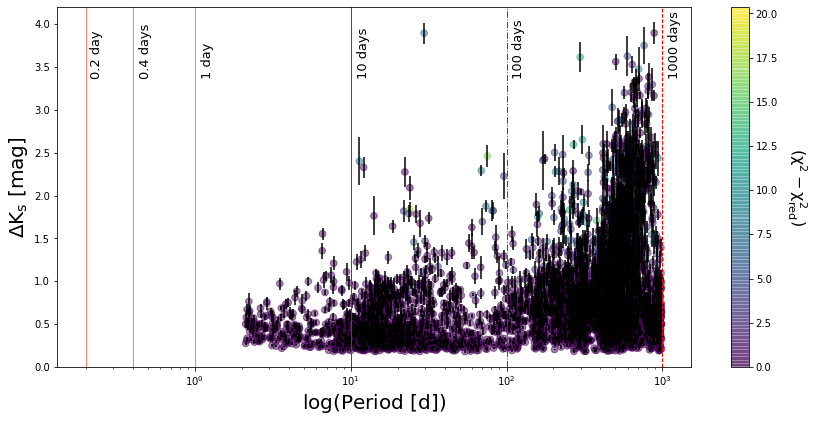

In [60]:
plt.figure(figsize=(12,6))

plt.errorbar(df['P'], df['DKs'],df['DKsboot'],0,',', linestyle='none', ecolor='black', capsize=0, ms=0)
sc=plt.scatter(df['P'], df['DKs'],c=(df['chi2']-df['chi2_cl']), s=45, alpha=0.5)

fz=10
fontsize = 20

#legend
cbar = plt.colorbar(sc)
cbar.set_label(r'${ \rm (\chi^{2} - \chi^{2}_{red}) }$', rotation=270, fontsize=16, labelpad=30)

plt.axvline(0.2,  lw=0.5, color='red',linestyle='-')
plt.axvline(0.4,  lw=0.5, color='red',linestyle='-')
plt.axvline(1,    lw=0.5, color='red',linestyle='-')
plt.axvline(10,   lw=1, color='red',linestyle='-')
plt.axvline(100,  lw=1, color='red',linestyle='-.')
plt.axvline(1000, lw=1, color='red',linestyle='--')

plt.text(0.235, 3.4, '0.2 day',   rotation=90, fontsize=13, horizontalalignment='center')
plt.text(0.48,  3.4, '0.4 days',  rotation=90, fontsize=13, horizontalalignment='center')
plt.text(1.2,   3.4, '1 day',     rotation=90, fontsize=13, horizontalalignment='center')
plt.text(12,    3.4, '10 days',   rotation=90, fontsize=13, horizontalalignment='center')
plt.text(120,   3.4, '100 days',  rotation=90, fontsize=13, horizontalalignment='center')
plt.text(1200,  3.4, '1000 days', rotation=90, fontsize=13, horizontalalignment='center')

plt.xlabel(r'${\rm log(Period\ [d])}$',fontsize=fontsize)
plt.ylabel(r'${\rm \Delta K_{s}\ [mag] }$',fontsize=fontsize)
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)

plt.ylim(0, 4.2)
plt.xscale('log')
plt.tight_layout()
#plt.savefig("BaelysDiagram.jpg", format='jpg',dpi=100)
plt.show()

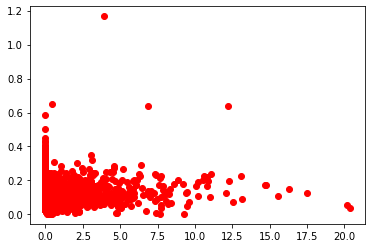

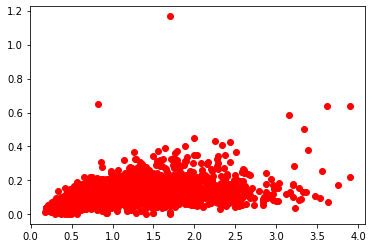

In [98]:
plt.plot(df['chi2']-df['chi2_cl'], df['Sigmacl'],'ro')
plt.show()
plt.plot(df['DKs'], df['Sigmacl'],'ro')

#Ra                             258.97
Dec                           -35.6857
Cat        258.97011082-35.68567106.lc
TileID                        b341_302
Epochs                              76
DKs                              0.501
DKsboot                           0.04
meanKs                          15.736
meanErr                          0.005
P                                2.115
Eta                               1.97
Poder                            0.638
chi2                             1.434
chi2_cl                          1.355
Sigmacl                          0.046
f_amp1                           0.149
f_amp2                           0.042
f_phs1                           1.099
f_phs2                           0.563
Name: 4100, dtype: object
258.97011082-35.68567106.lc
264.26197744-30.8265241.lc


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


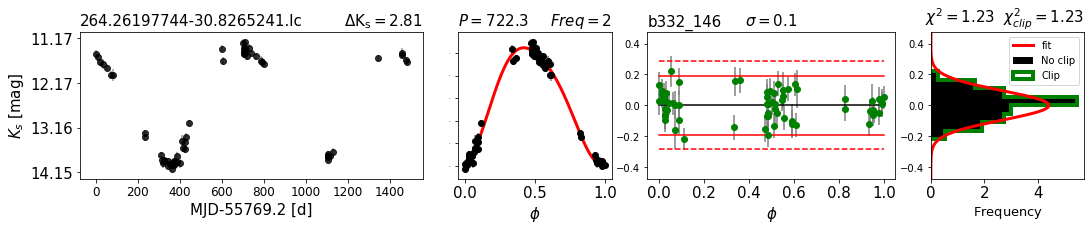

268.0265971-26.7413267.lc


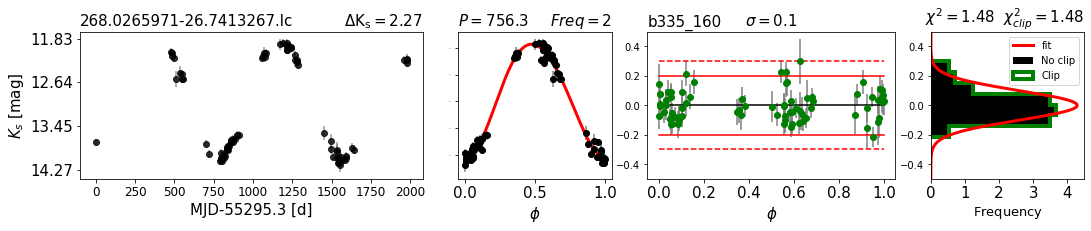

269.4098102-23.6722759.lc


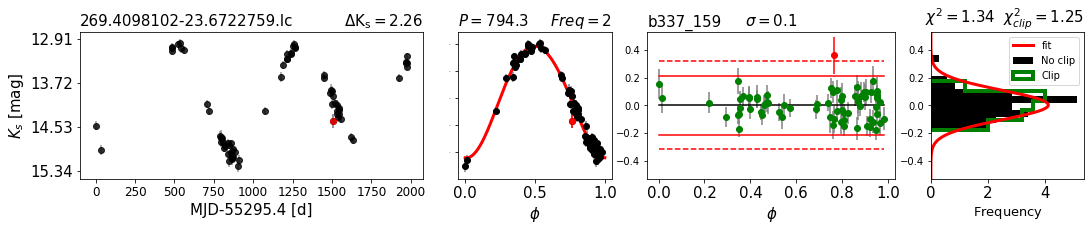

260.36203278-35.95790911.lc


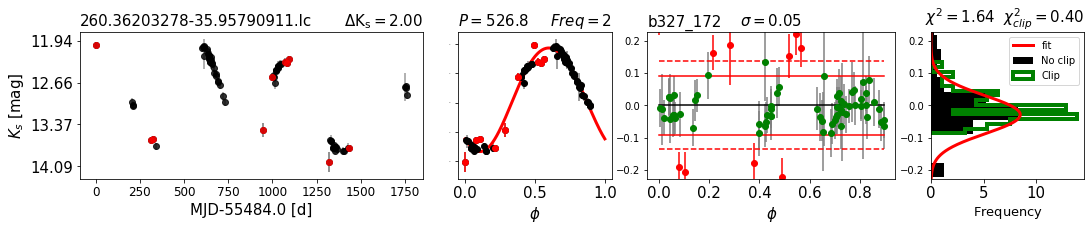

261.07584994-36.57765625.lc


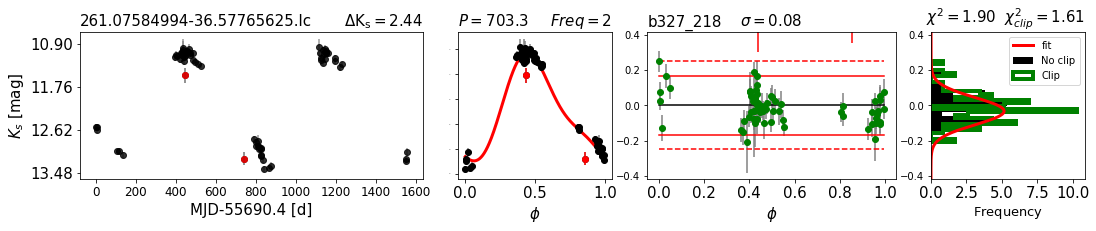

270.39192814-22.84676271.lc


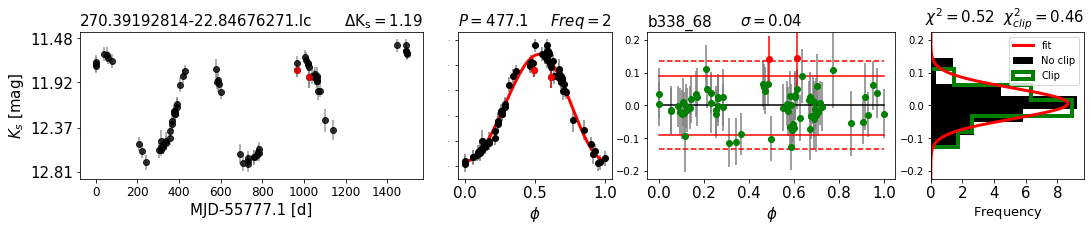

259.9930139-36.48434739.lc


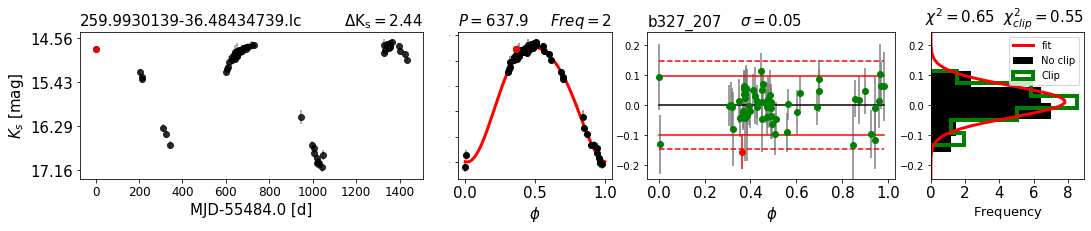

261.05024771-36.04293523.lc


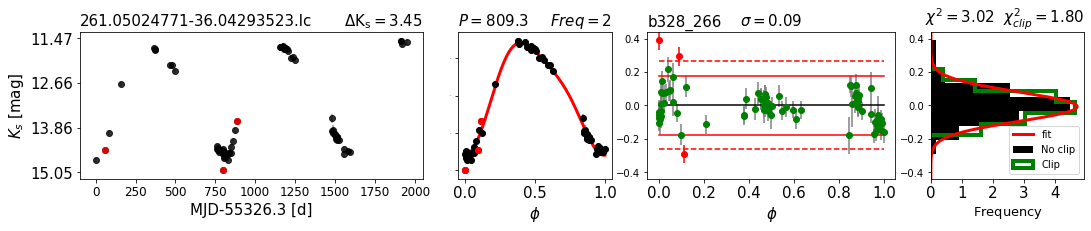

262.8151507-32.3248036.lc


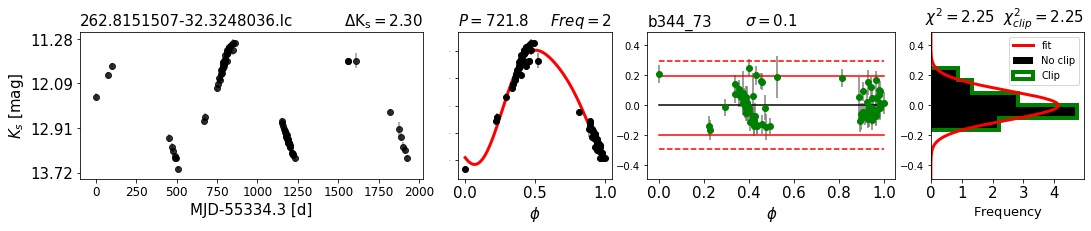

263.8617613-33.9059805.lc


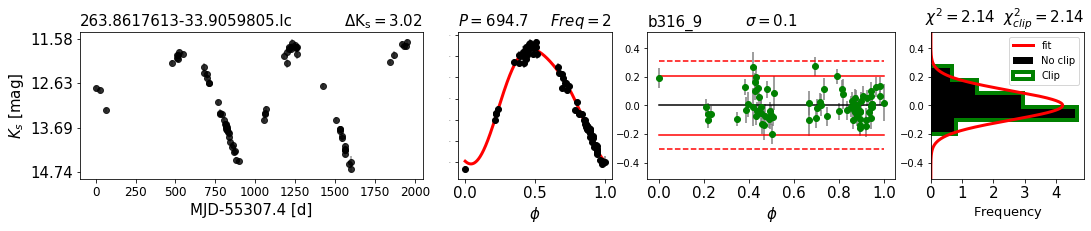

270.46635919-24.00234708.lc


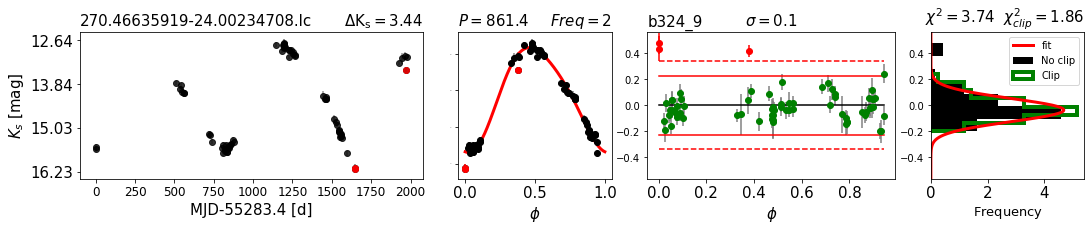

261.06856532-35.02824198.lc


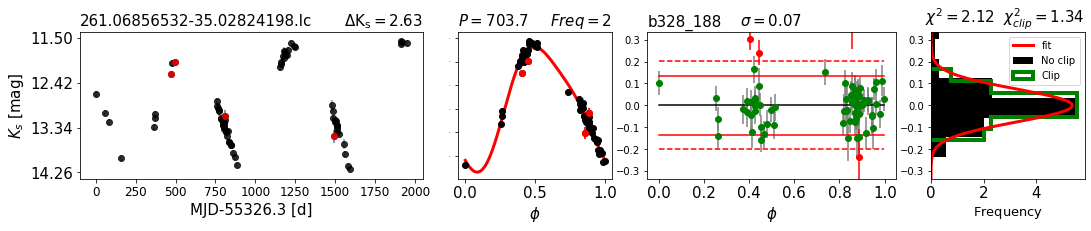

259.60398157-35.9577986.lc


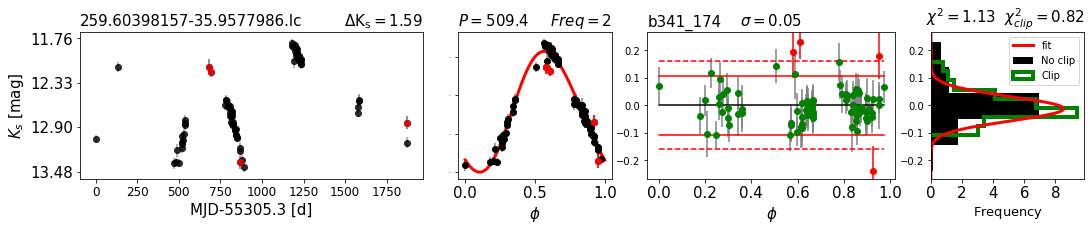

264.9256155-32.2289735.lc


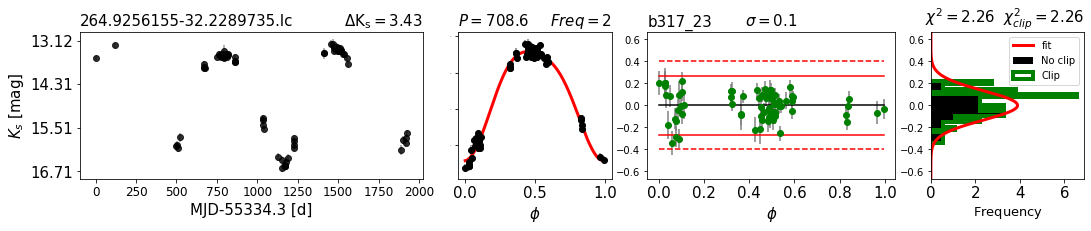

266.77412083-29.24494807.lc


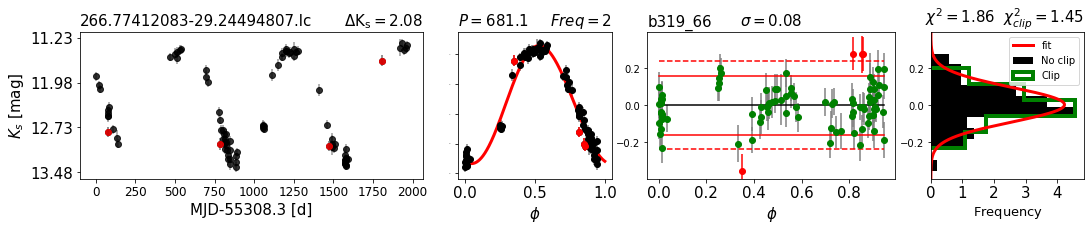

268.7993642-26.4586193.lc


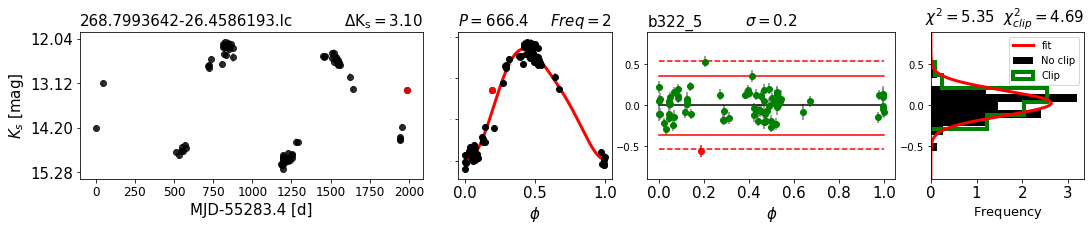

265.5942035-27.397057.lc


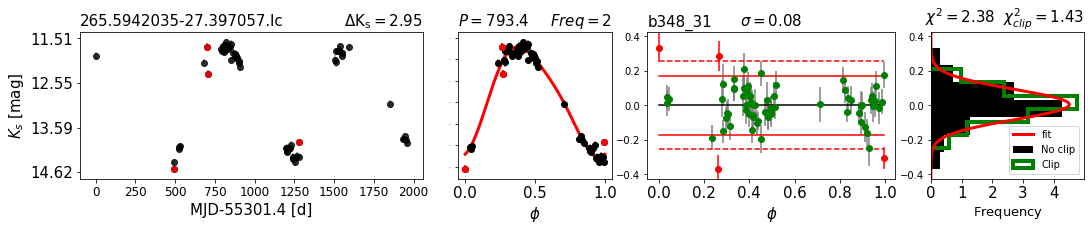

266.9141142-26.7277056.lc


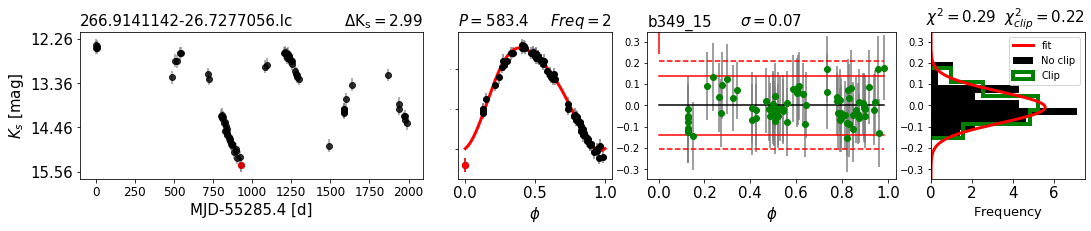

267.1742546-25.1780989.lc


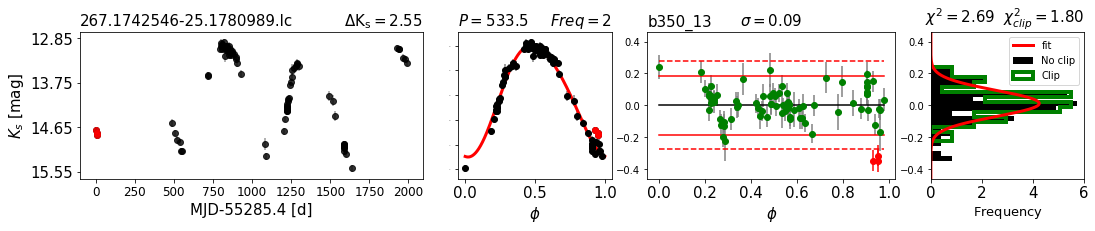

269.5740159-25.3820583.lc


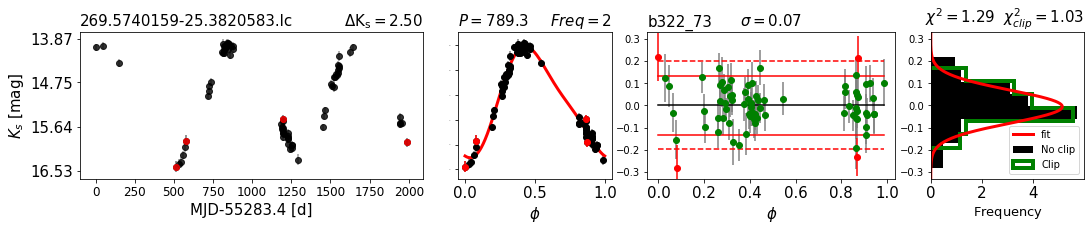

260.9779106-35.53709932.lc


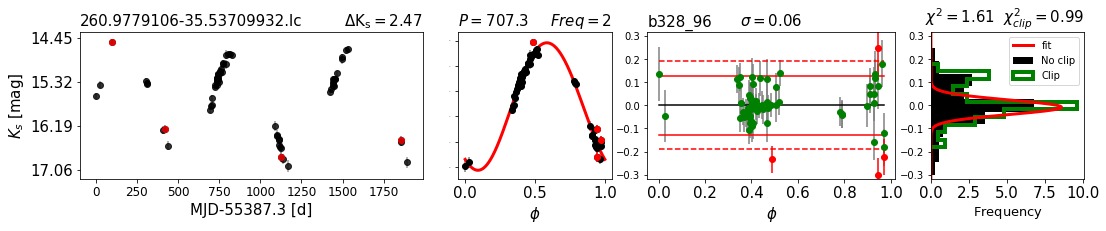

263.1938412-32.2045511.lc


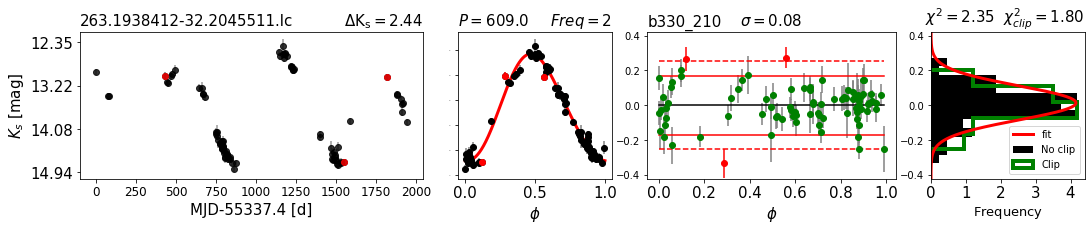

268.6561481-23.5574762.lc


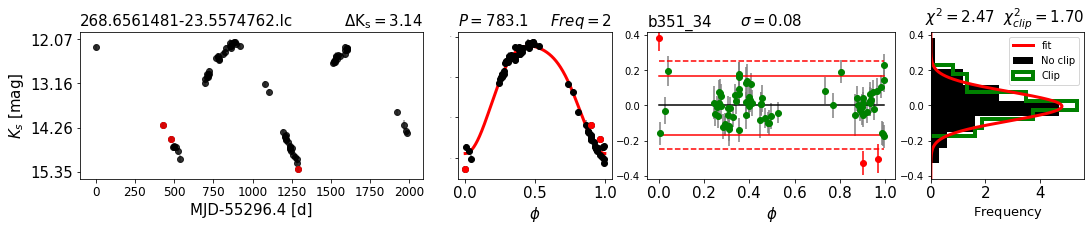

266.82189481-30.47403096.lc


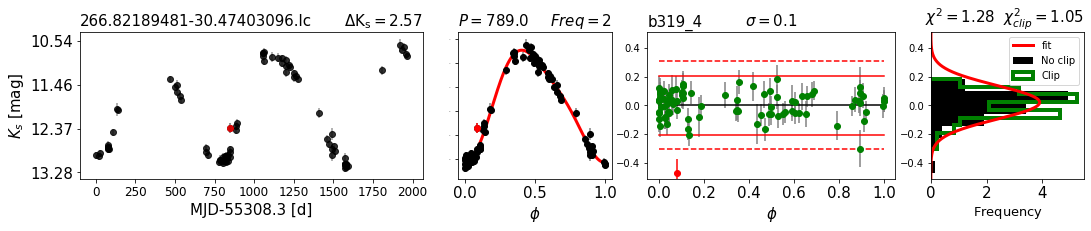

261.39884691-35.37716291.lc


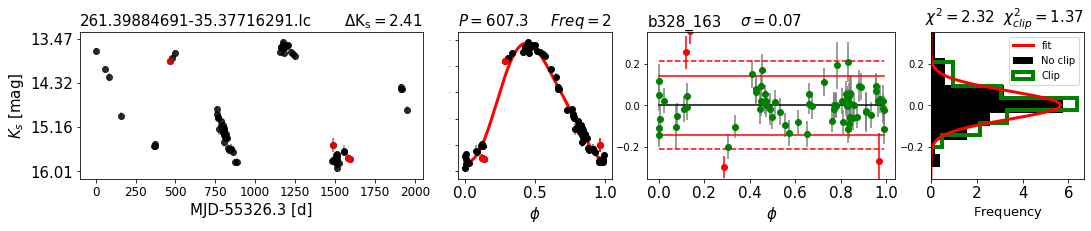

264.1157143-31.7265432.lc


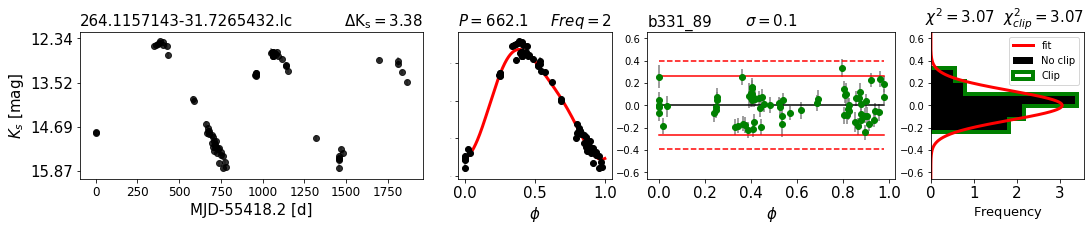

264.5292784-31.1092527.lc


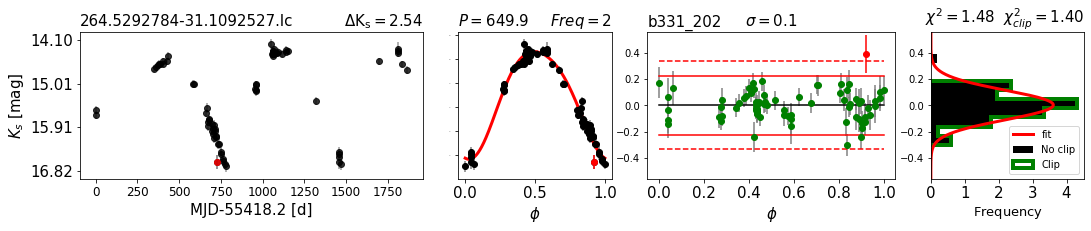

266.90189265-29.45739083.lc


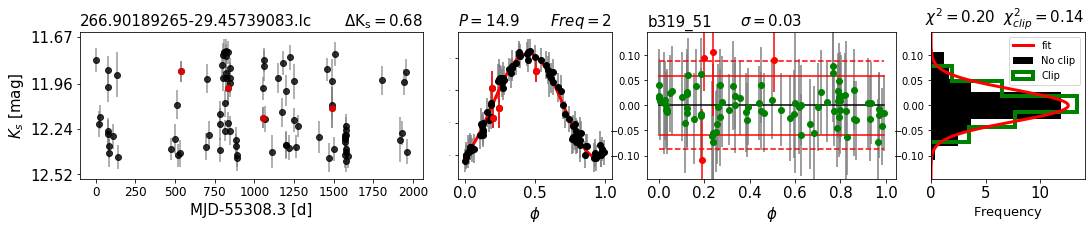

260.22488327-36.71914582.lc


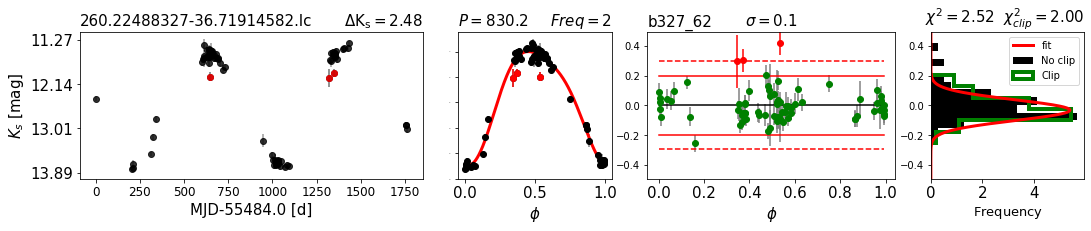

272.0232564-20.6935056.lc


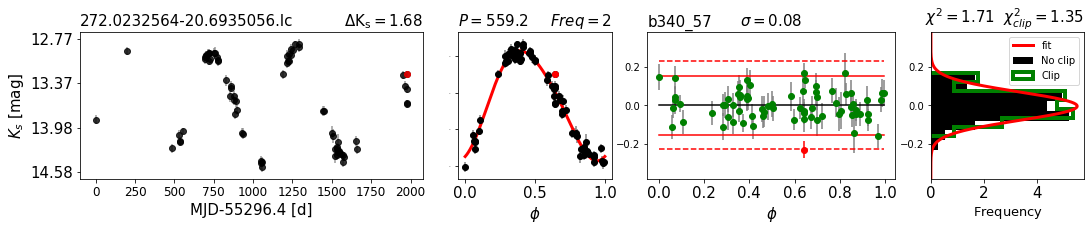

262.1439952-35.5237763.lc


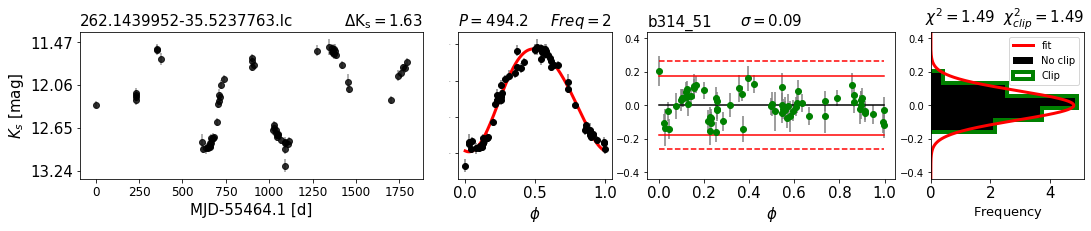

266.3466601-30.5630064.lc


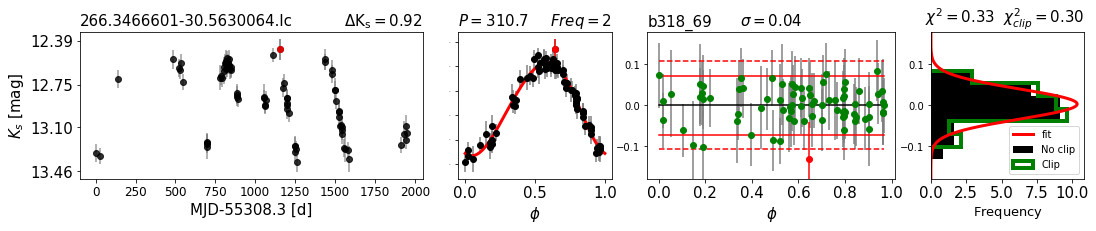

267.12583153-29.12313202.lc


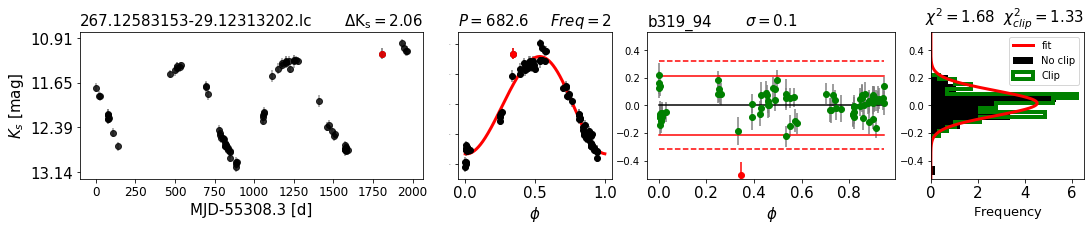

268.7122415-26.6710941.lc


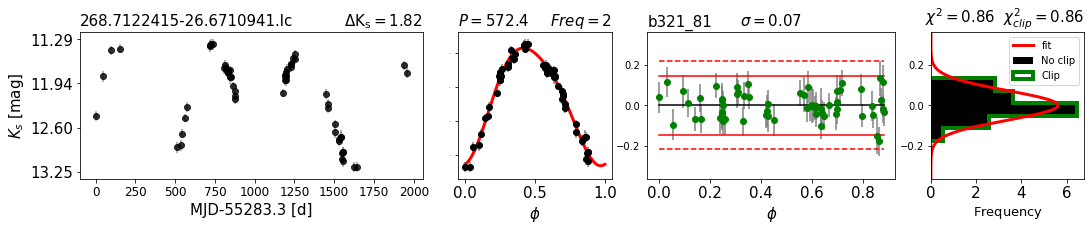

264.73880909-30.83038931.lc


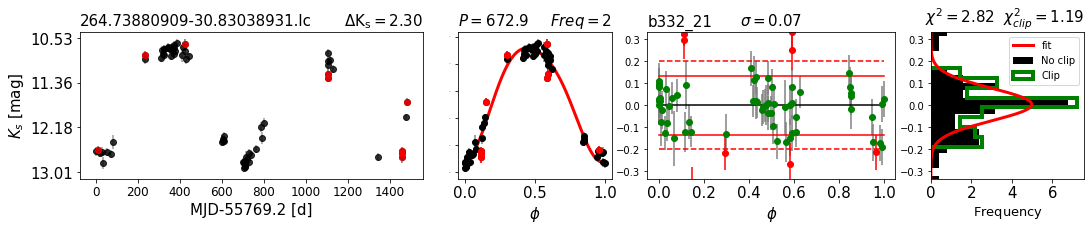

264.52927967-31.10924142.lc


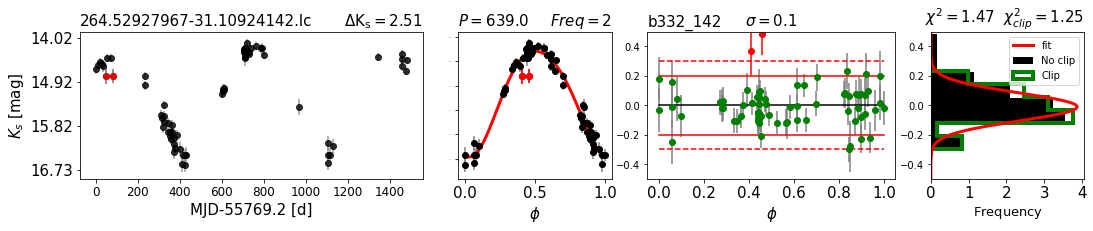

263.1947885-30.9094983.lc


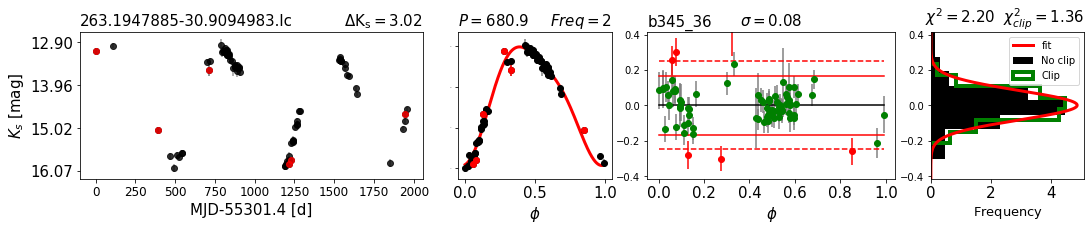

268.7810985-22.0254804.lc


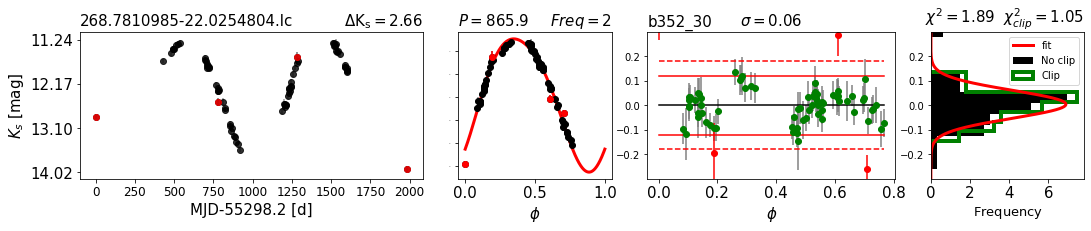

262.13934999-33.82368775.lc


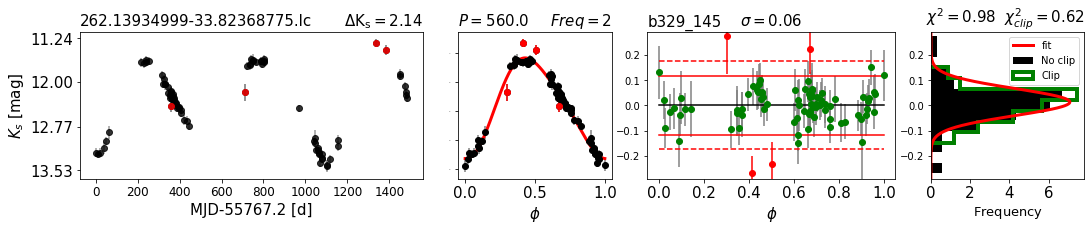

269.8459442-23.8289597.lc


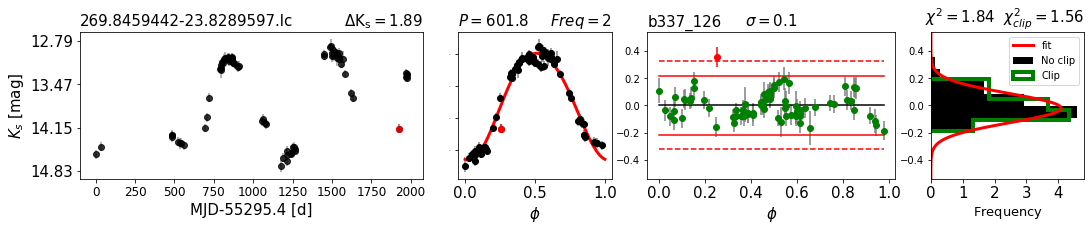

271.4859473-21.0053184.lc


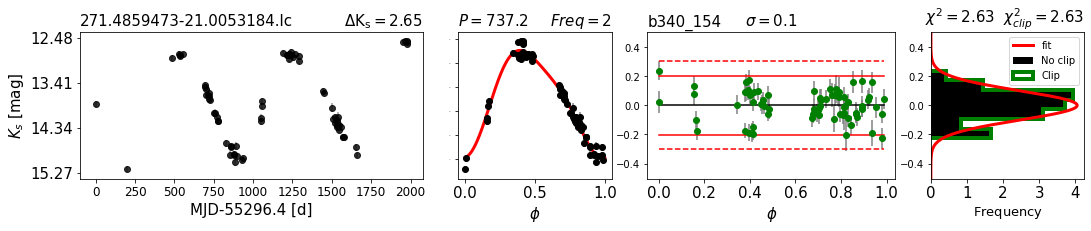

262.6115705-30.8863193.lc


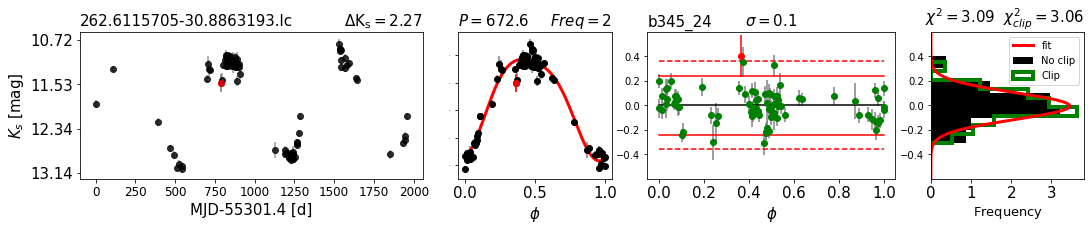

267.5986817-28.9466963.lc


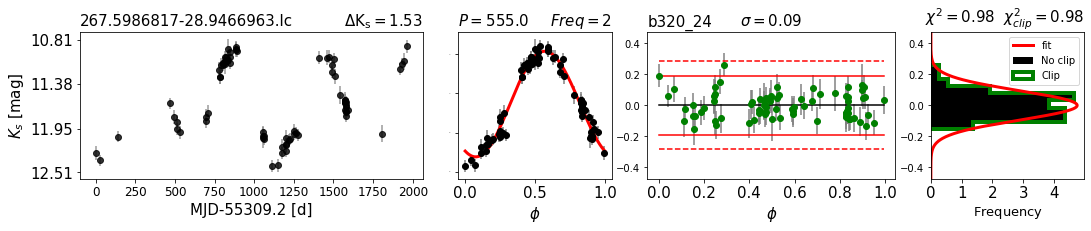

267.6186435-26.904258.lc


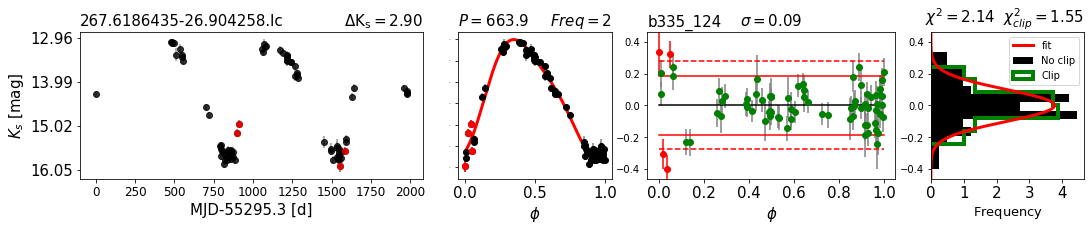

269.6900722-24.3566037.lc


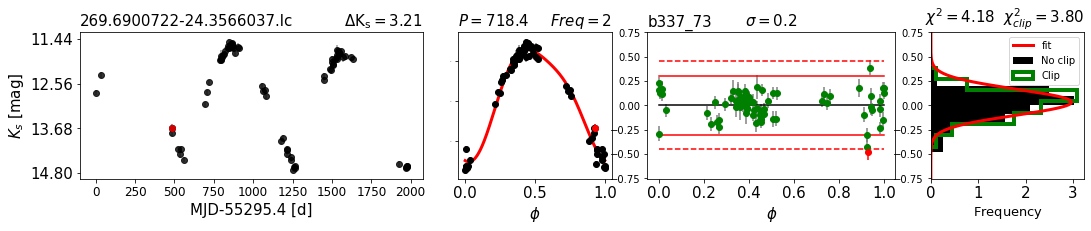

270.1353732-21.6539082.lc


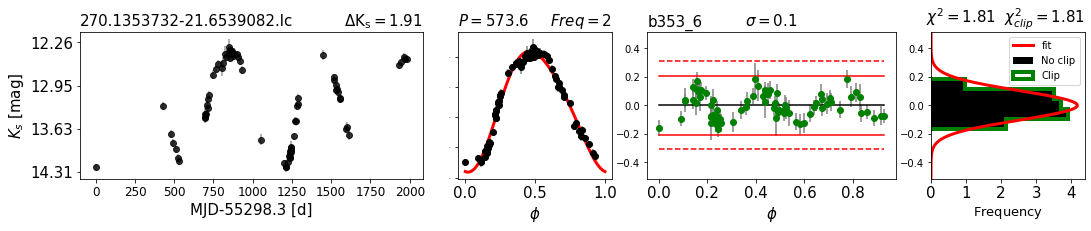

261.0758778-36.5776842.lc


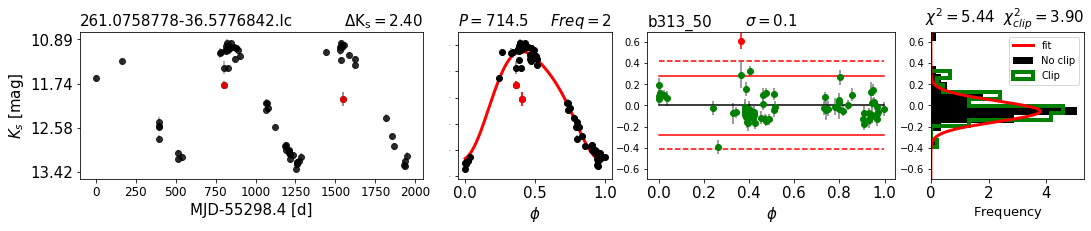

269.5021555-26.5692471.lc


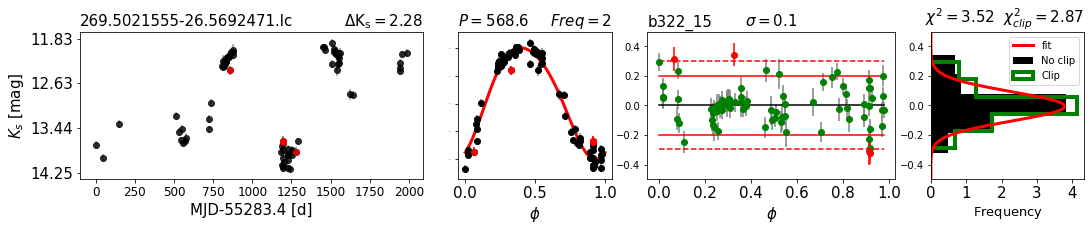

268.9863967-25.8372302.lc


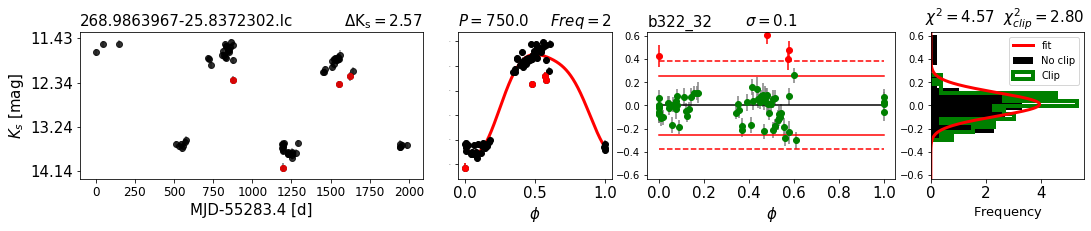

264.8749006-31.602974.lc


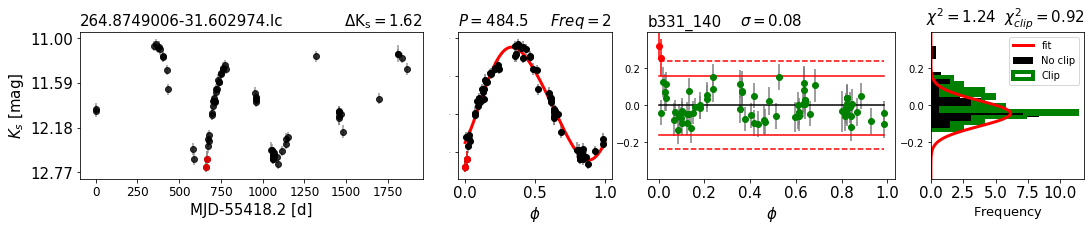

264.58202093-31.10263618.lc


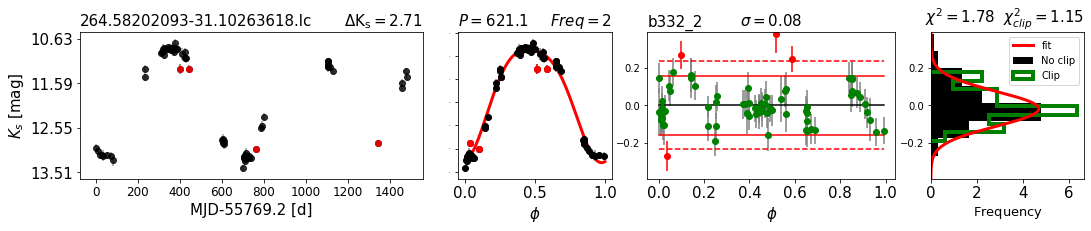

265.58374696-30.12860611.lc


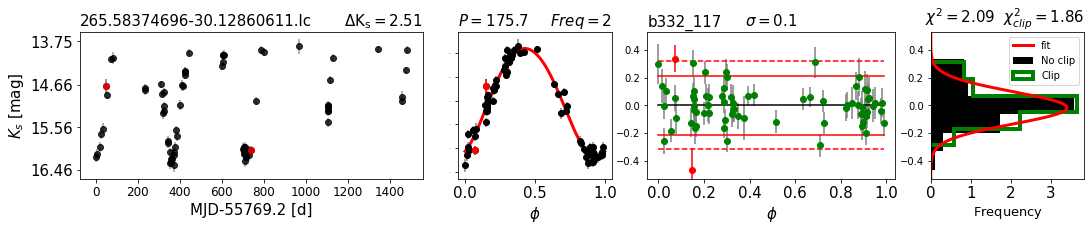

260.28800346-35.47602423.lc


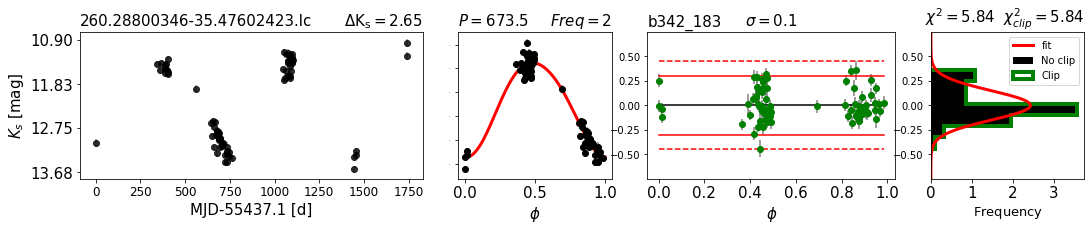

264.875185-28.0594416.lc


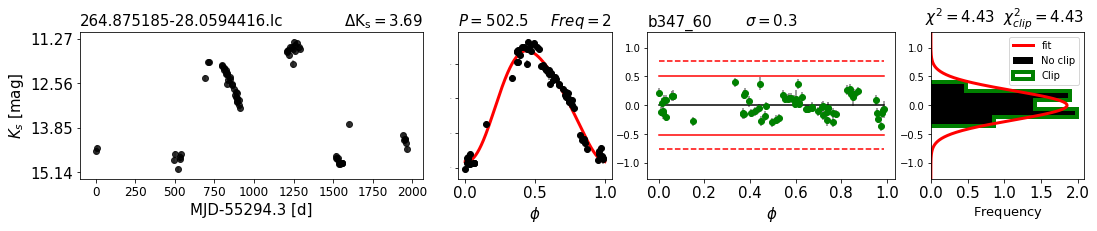

265.38173556-30.42281562.lc


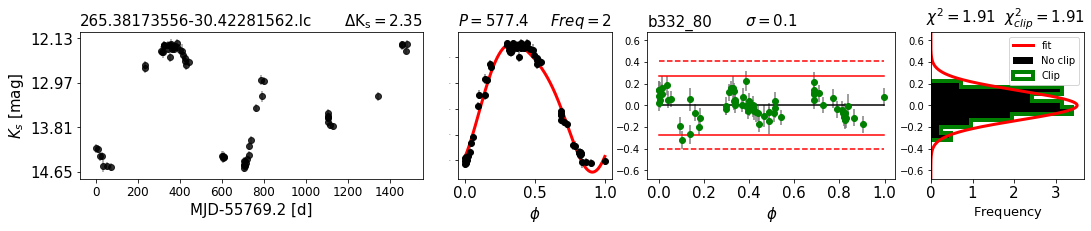

In [93]:
#Sólo con el indice, podemos obtener toda la información de una variable en particular.
#En este caso, la de mayor amplitud:
ind = np.argmin(df['P'])
MayorAmplitud=df.loc[ind]
print(MayorAmplitud)
print(MayorAmplitud['Cat'])



asd = df.nlargest(55, ['Poder'])

#asd = df.nsmallest(45, ['P'])



for i in range(0, len(asd)):
    
    tile, blah = asd.iloc[i]['TileID'].split('_')
    
    print(asd.iloc[i]['Cat'])
    
    _= PSA(asd.iloc[i]['Cat'], asd.iloc[i]['P'], path=path_datos+tile+'_data/GLS', N_frec=2, sigmaClip=3, \
       ID=asd.iloc[i]['Cat'], tile=asd.iloc[i]['TileID'], plot=True)
    plt.show()





/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


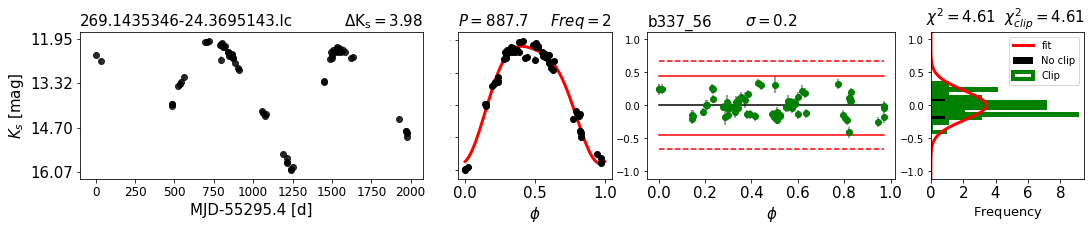

In [40]:
_= PSA(MayorAmplitud['Cat'], MayorAmplitud['P'], path=path_datos+'b337_data/GLS', N_frec=2, sigmaClip=3, \
       ID=MayorAmplitud['Cat'], tile=MayorAmplitud['TileID'], plot=True)

In [53]:
import FATS

SyntaxError: invalid syntax (Feature.py, line 93)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


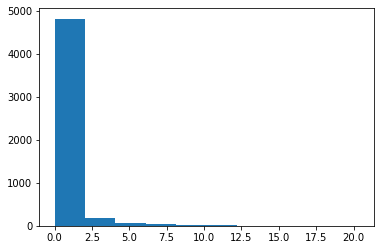

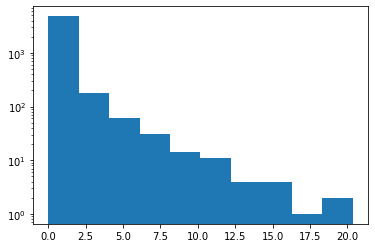

In [39]:
_,_,_ = plt.hist(df['chi2'] - df['chi2_cl'] , bins=nbins(len(df['chi2'])))
plt.show()
_,_,_ = plt.hist(df['chi2'] - df['chi2_cl'] , bins=nbins(len(df['chi2'])))
plt.yscale('log')
plt.show()

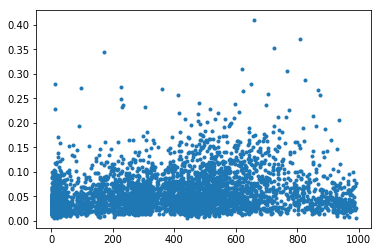

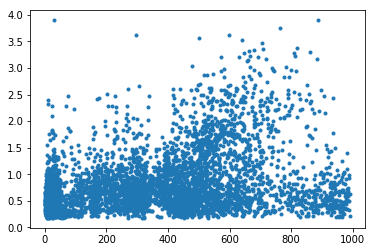

In [55]:
plt.plot(period, DKs_err,'.')
plt.show()
plt.plot(period, DKs_boot,'.')
plt.show()


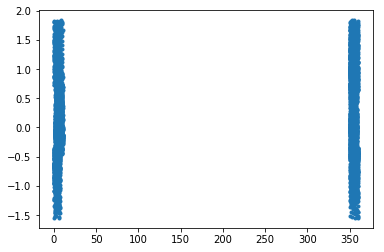

In [58]:
l,b = ReadCords(Ra,Dec)
plt.plot(l,b,'.')

In [ ]:
lista_tiles = np.genfromtxt('./'+subgrupo+'lista_tiles.cat', dtype=str)

print lista_tiles

c=0

nombre_archivo = 'IP_prueba'


f = open(nombre_archivo+'.cat','w')
f.write('#Ra		 Dec		 Cat				 TileID		 Epochs  DKs	 meanKs	 meanErr P	 Eta	 chi2	 chi2_cl Sigmacl f_amp1	f_amp2	f_phs1	f_phs2\n')

numeroID = 1

for tile in lista_tiles:
    
    path= './'+subgrupo+tile+'/IP/'
    print path
    
    IP = ReadFile('IP_cand.list', path=path)
    
    #vamos a elegir las que tengan Power < 0.9
    
    #Sample = np.array([GLS[i] for i in range(len(GLS[:,0])) if GLS[i,7]< 0.9])

    cat = IP[:,2]
    P = IP[:,7]
    
    for j in range(len(cat)):
        c +=1
        mjd,mag,err = Readlc(cat[j],path=path)
        
        
        Ra,Dec  = Coords(cat[j])
        Epochs = len(mjd)

        meanKs, meanErr = MeanKs_bootstrap(mag)
        DKs_boot,DKs_err = DKs_bootstrap(mag)
        #power  = catalogo_sort[i,7]
        tileID = tile
        Eta = eta(mjd,mag)
        ID = tile+'_'+str(numeroID)
        
        
        chi2,chi2_clip,Sigma_clip,f_amp,f_phs = PSA(cat[j], P[j], path=path, \
                        N_frec=2, sigmaClip=3, ID=cat[j], tile=tile, columnadoble=False, plot=False)
        #plt.tight_layout()
        

        #plt.tight_layout()
        #pdf.savefig()
        #plt.show()

        f.write("%0.7f\t %0.7f\t %s\t %s\t %g\t %.3f\t %.3f\t %.3f\t %.3f\t %.3f\t %.3f\t %0.3f\t %.3f\t %.3f\t %.3f\t %.3f\t%.3f\t%.3f\n" \
        %(Ra,Dec,cat[j],ID,Epochs,DKs_boot,DKs_err,meanKs,meanErr,P[j],Eta,chi2,chi2_clip,Sigma_clip,f_amp[0],f_amp[1],f_phs[0],f_phs[1]))
        f.flush()  
        #plt.show()
print c
f.close()

## Primeras pruebas :o